In [70]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join

from nilearn import plotting
import ipywidgets; ipywidgets.__version__

from skimage import measure, morphology

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

import scipy.ndimage
from numpy import copy

import ipyvolume as ipv
import plotly.plotly as py
import plotly.graph_objs as go

In [71]:
img = nib.load('../data/raw/086e42f6-2077-4d8c-a713-6eddd58a4177_TrainingSet_1_of_2/TrainingSet_1_of_2/CTR_TRN_002.nii.gz')

In [4]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume, figsize=(10, 10)):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots(figsize=figsize)
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    

<IPython.core.display.Javascript object>


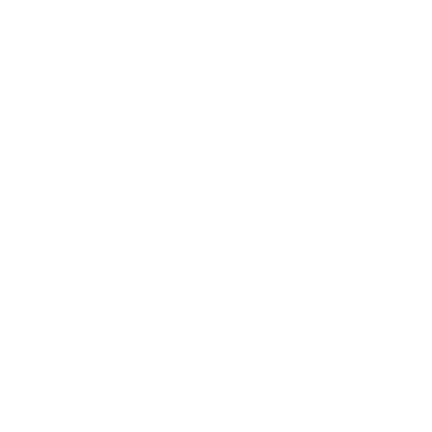

<IPython.core.display.Javascript object>


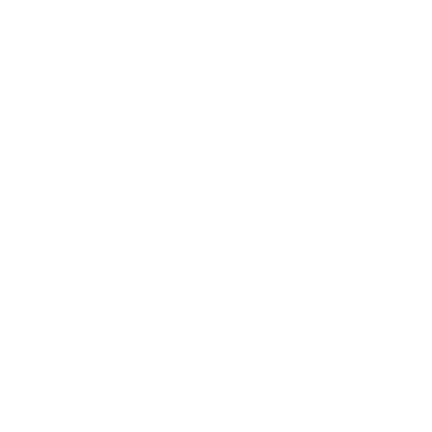

In [51]:
%matplotlib notebook

multi_slice_viewer(np.swapaxes(img.get_data(), 0, 2), figsize=(6, 6))

KeyboardInterrupt: 

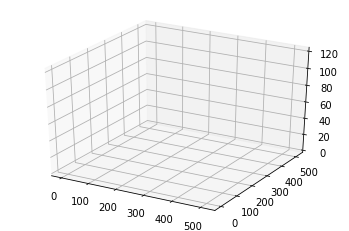

In [7]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(img.get_data())



IndexError: index 122 is out of bounds for axis 2 with size 122

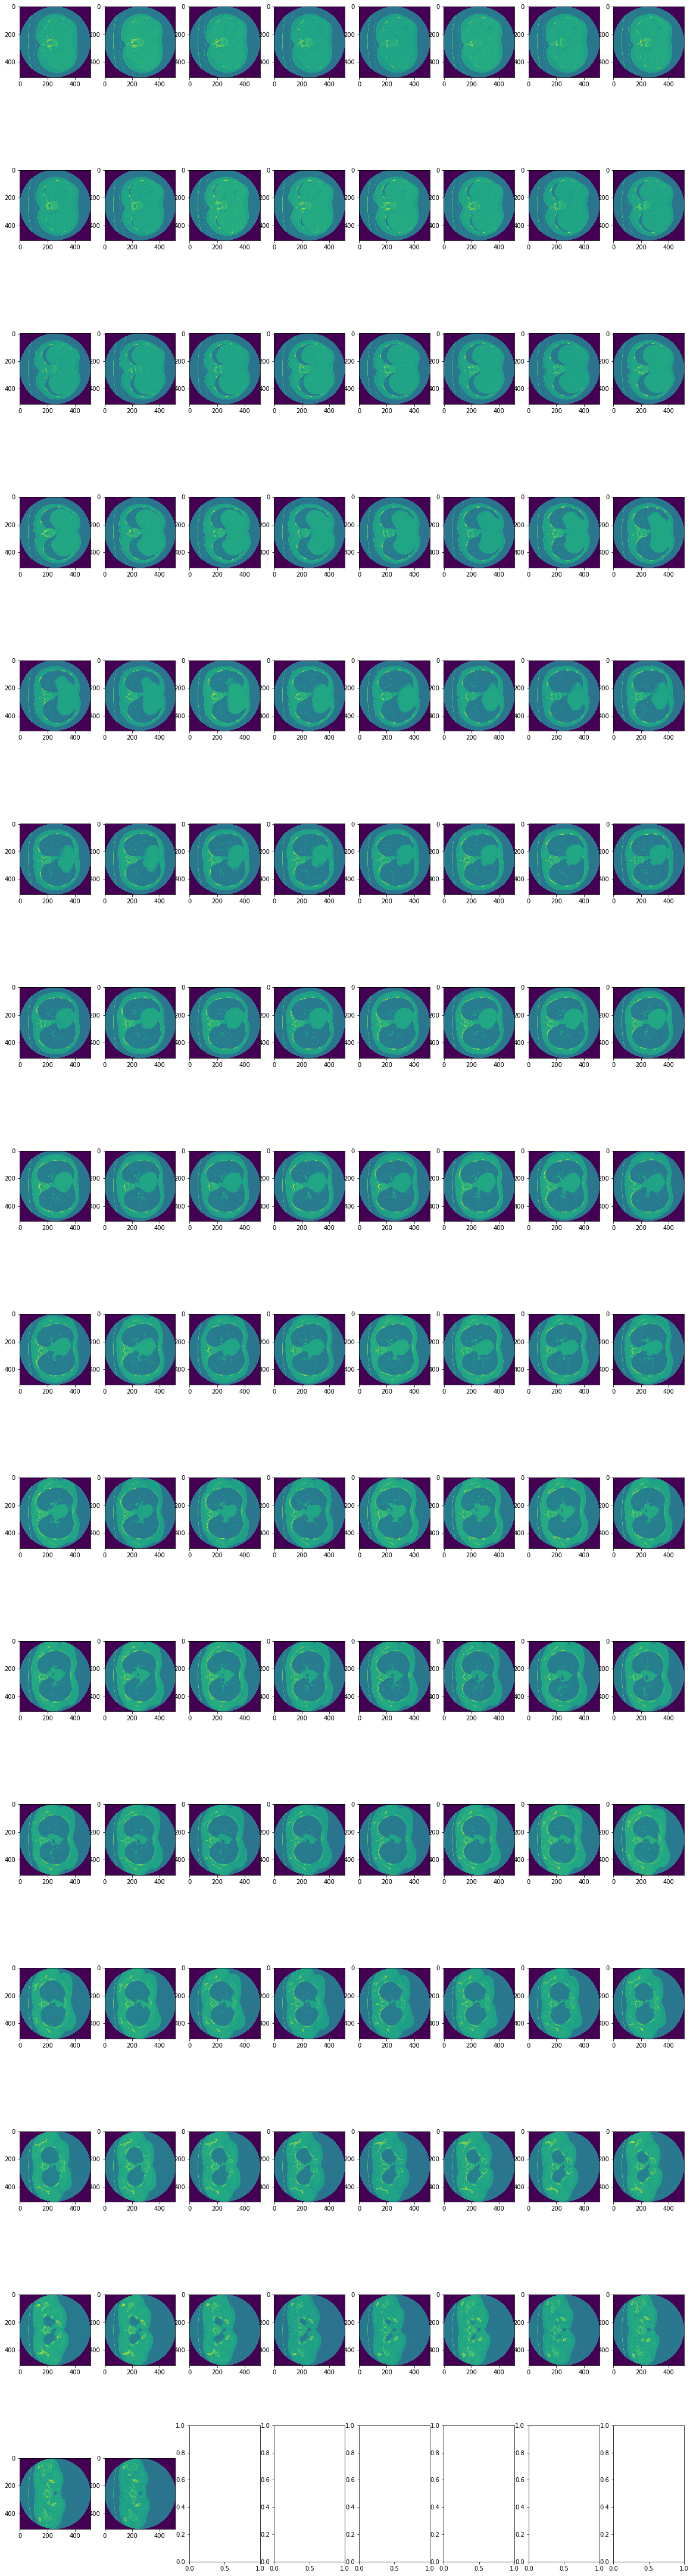

In [31]:
%matplotlib inline

_, axarr = plt.subplots(16, 8, figsize=(20, 80))
axarrs = [ax for axrow in axarr for ax in axrow]

for idx, ax in enumerate(axarrs):
    ax.imshow(img.get_data()[:, :, idx])

In [ ]:


plotting.plot_stat_map('../data/raw/086e42f6-2077-4d8c-a713-6eddd58a4177_TrainingSet_1_of_2/TrainingSet_1_of_2/CTR_TRN_001.nii.gz')

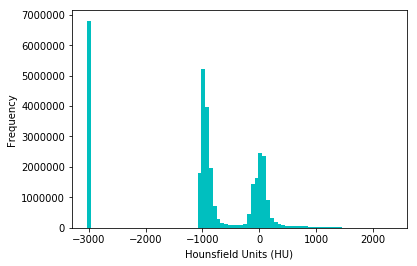

In [32]:
plt.hist(img.get_data().flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [5]:

%matplotlib inline
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(0,1,2)
    p = p[:,:,::]
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    #ax = Axes3D(fig) 
    ax = fig.add_subplot(111, projection='3d') 

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
#plot_3d(img.get_data())

[ True  True  True ...  True  True  True]
-18373200
(512, 512, 130)


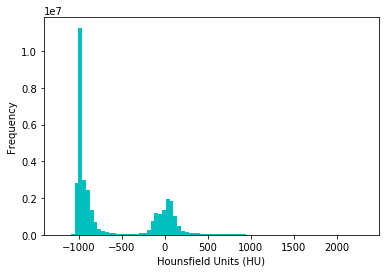

In [7]:
%matplotlib inline

data2 = img.get_data()


#data2 = [data2.where(data2==-2000, -1000, data2) for data in img.get_data() for data2 in data ]  

data3 = np.where(img.get_data()<=-2000, -1000, data2)

a = np.array(img.get_data().flatten())
b = [a < -2000][0]
print(b)
c = np.where(b == True)
d = np.where(b == False)
print(len(c[0]) - len(d[0]))

# print(data3.shape)
def resample(image):#, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([1,1,0.02]))
#     spacing = np.array(list(spacing))

#     resize_factor = spacing / new_spacing
#     new_real_shape = image.shape * resize_factor
#     new_shape = np.round(new_real_shape)
#     real_resize_factor = new_shape / image.shape
#     new_spacing = spacing / real_resize_factor
    desiredshape = 130.05504587155963
    real_resize_factor = desiredshape / image.shape[2]
    image = scipy.ndimage.interpolation.zoom(image, [1,1,real_resize_factor])
    
    return image#, new_spacing

data3 = resample(data3)
print(data3.shape)

plt.hist(data3.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


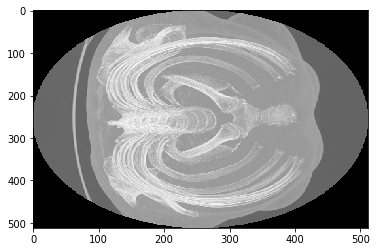

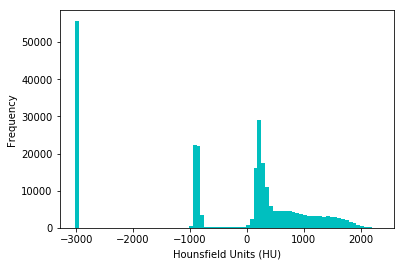

In [59]:
data3 = img.get_data()
first_patient_merge=data3[:,:,0]

for i in range(1, data3.shape[2]):
    imgData = data3[:,:,i]
    first_patient_merge=np.maximum(first_patient_merge,imgData)

plt.imshow(first_patient_merge, cmap=plt.cm.gray, aspect = 'auto')
plt.show()

plt.hist(first_patient_merge.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


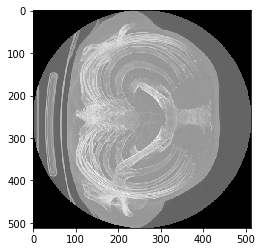

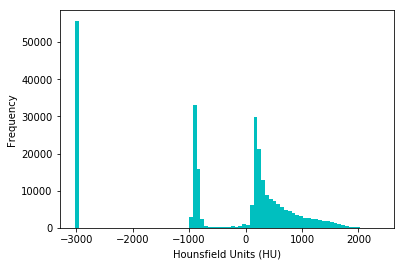

In [22]:

# roi=[first_patient_merge <= -100]
# print(roi)

first_patient_merge2=first_patient_merge
# first_patient_merge2[tuple(roi)]=-2000
# first_patient_merge2[first_patient_merge2 <= -1000] = 2000
# first_patient_merge2[first_patient_merge2 <= -500] = -2000
# first_patient_merge2[first_patient_merge2 > -500] = 2000

for x in first_patient_merge2:
    for y in x:
            if y <= -100:
                y = -2000
for x in first_patient_merge2:
    for y in x:
            if y <= -1000:
                y = 2000
for x in first_patient_merge2:
    for y in x:
            if y <= -500:
                y = -2000
for x in first_patient_merge2:
    for y in x:
            if y > -500:
                y = 2000

plt.imshow(first_patient_merge2, cmap=plt.cm.gray)
plt.show()

plt.hist(first_patient_merge2.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

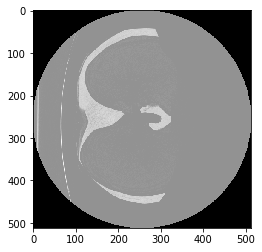

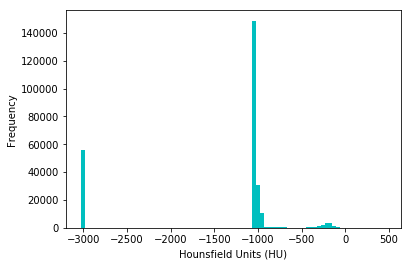

NameError: name 'first_patient_empty2' is not defined

In [23]:
r1 = 1
r2 = data3.shape[2]
first_patient_empty=data3[:,:,r1]

for i in range (r1,r2):
    first_patient_empty=np.minimum(first_patient_empty,data3[:,:,i])

plt.imshow(first_patient_empty, cmap=plt.cm.gray)
plt.show()

plt.hist(first_patient_empty.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# first_patient_empty2=first_patient_empty
# first_patient_empty2[roi]=-2000
# first_patient_empty2[first_patient_empty2 <= -1000] = 2000
# first_patient_empty2[first_patient_empty2 <= -500] = -2000
# first_patient_empty2[first_patient_empty2 > -500] = 2000

for x in first_patient_empty2:
    for y in x:
            if y <= -100:
                y = -2000
for x in first_patient_empty2:
    for y in x:
            if y <= -1000:
                y = 2000
for x in first_patient_empty2:
    for y in x:
            if y <= -500:
                y = -2000
for x in first_patient_empty2:
    for y in x:
            if y > -500:
                y = 2000

plt.imshow(first_patient_empty2, cmap=plt.cm.gray)
plt.show()

In [ ]:
first_patient_diff3=np.maximum(first_patient_merge2,first_patient_empty2)
plt.imshow(first_patient_diff3, cmap=plt.cm.gray)
plt.show()

In [72]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

segmented_lungs = segment_lung_mask(data3, False)
segmented_lungs_fill = segment_lung_mask(data3, True)

# segmented_lungs = segment_lung_mask(img.get_data(), False)
# segmented_lungs_fill = segment_lung_mask(img.get_data(), True)

In [ ]:
plot_3d(segmented_lungs, 0)
plot_3d(segmented_lungs_fill, 0)

In [ ]:
#%matplotlib notebook
%matplotlib inline
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [107]:
firstDataSetPath = "/home/augt/Public/License2019/clef2019_tuberculosis/data/raw/086e42f6-2077-4d8c-a713-6eddd58a4177_TrainingSet_1_of_2/TrainingSet_1_of_2"
secondDataSetPath = "/home/augt/Public/License2019/clef2019_tuberculosis/data/raw/07224578-0898-497a-b21d-94fbf883b974_TrainingSet_2_of_2/TrainingSet_2_of_2"

resampleFolder = "/home/augt/Public/License2019/clef2019_tuberculosis/data/interim/resampledImages/"

for f in listdir(firstDataSetPath):
    if isfile(join(firstDataSetPath, f)):
        auxImage = nib.load(firstDataSetPath + '/' + f);
        #print(auxImage.shape)
        auxImage = resample(auxImage.get_data())
        np.save(resampleFolder + f, auxImage)
        
for f in listdir(secondDataSetPath):
    if isfile(join(secondDataSetPath, f)):
        auxImage = nib.load(secondDataSetPath + '/' + f);
        #print(auxImage.shape)
        auxImage = resample(auxImage.get_data())
        np.save(resampleFolder + f, auxImage)
        
        

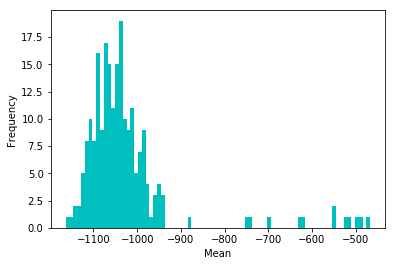

-1031.3526037498798


In [31]:
### get mean of first set

firstDataSetPath = "/home/augt/Public/License2019/clef2019_tuberculosis/data/raw/086e42f6-2077-4d8c-a713-6eddd58a4177_TrainingSet_1_of_2/TrainingSet_1_of_2"
secondDataSetPath = "/home/augt/Public/License2019/clef2019_tuberculosis/data/raw/07224578-0898-497a-b21d-94fbf883b974_TrainingSet_2_of_2/TrainingSet_2_of_2"

meanSum = 0
meanCardinal = 0
means = []

meanSum2 = 0
meanCardinal2 = 0
means2 = []

imagesDimensions = []

for f in listdir(firstDataSetPath):
    if isfile(join(firstDataSetPath, f)):
        #print(f)
        
        auxImage = nib.load(firstDataSetPath + '/' + f);
        #print(auxImage.shape)
        
        auxMean = auxImage.get_data().mean(dtype=np.float64)
        #print(auxMean)
        
        meanSum += auxMean * auxImage.shape[2]
        meanCardinal += auxImage.shape[2]
        
        means.append(auxMean)
        
        imagesDimensions.append(auxImage.shape[2])
        
for f in listdir(secondDataSetPath):
    if isfile(join(secondDataSetPath, f)):
        #print(f)
        
        auxImage2 = nib.load(secondDataSetPath + '/' + f);
        #print(auxImage2.shape)
        
        auxMean2 = auxImage2.get_data().mean(dtype=np.float64)
        #print(auxMean2)
        
        meanSum2 += auxMean2 * auxImage2.shape[2]
        meanCardinal2 += auxImage2.shape[2]
        
        means2.append(auxMean2)
        
        imagesDimensions.append(auxImage.shape[2])

        

plt.hist(means+means2, bins=80, color='c')
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.show()


print(((meanSum/meanCardinal)*meanCardinal + (meanSum2/meanCardinal2)*meanCardinal2)/(meanCardinal + meanCardinal2))

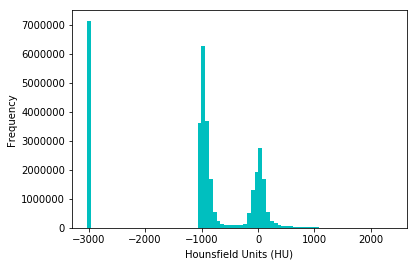

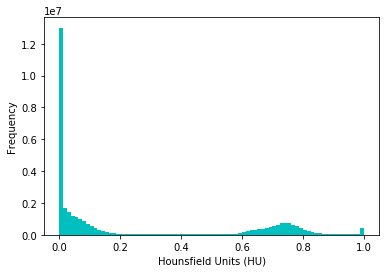

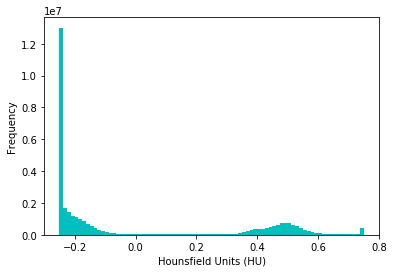

In [11]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0

data = img.get_data()
data1 = segmented_lungs_fill - segmented_lungs
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

plt.hist(data.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

data = normalize(data)

plt.hist(data.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


data = zero_center(data)

plt.hist(data.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [33]:
#print(img.header)<

#get the mean of sections (z ax)
m2 = len(means2)
m1 = len(means)

np.mean(imagesDimensions)
################################

130.05504587155963

In [36]:
data4 = np.where(img.get_data()<=-2000, -1000, img.get_data())

def resample2(image):
    desireddeep = 130.05504587155963
    real_resize_factor = desireddeep / image.shape[2]
    
    desiredheight = 256
    real_resize_factor_height = desiredheight / image.shape[1]
    
    desiredwidth = 256
    real_resize_factor_width = desiredwidth / image.shape[0]
    
    image = scipy.ndimage.interpolation.zoom(image, [real_resize_factor_height, real_resize_factor_width, real_resize_factor])
    
    return image

data4 = resample2(data4)

segmented_lungs = segment_lung_mask(data4, False)
segmented_lungs_fill = segment_lung_mask(data4, True)



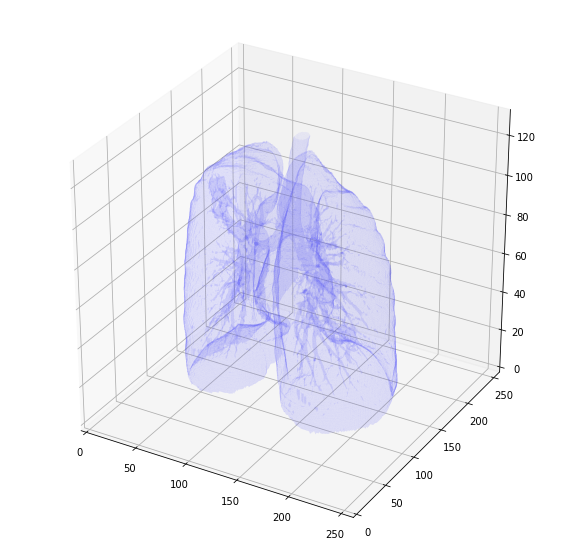

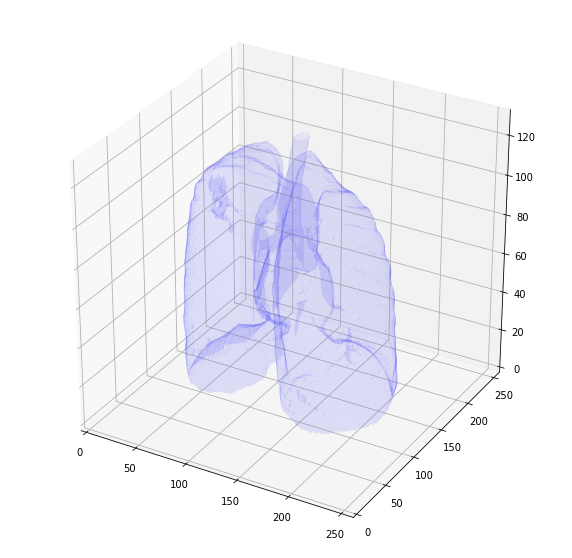

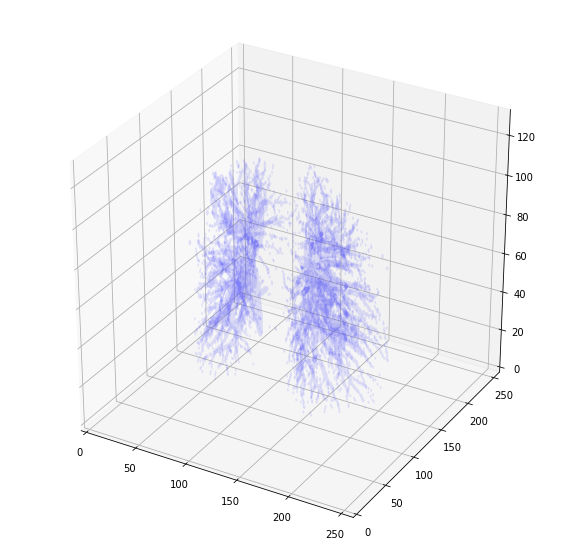

In [13]:
%matplotlib inline
plot_3d(segmented_lungs, 0)
plot_3d(segmented_lungs_fill, 0)
#%matplotlib notebook

plot_3d(segmented_lungs_fill - segmented_lungs, 0)

(512, 512, 130)
(248607, 3) (497580, 3)
[[ 72. 259.  76.]
 [ 71. 259.  77.]
 [ 72. 258.  77.]
 ...
 [457. 285.  30.]
 [457. 286.  29.]
 [457. 286.  30.]] [[     0      1      2]
 [     3      2      1]
 [     1      4      3]
 ...
 [248532 248605 248533]
 [248533 248605 248606]
 [248527 248533 248606]]


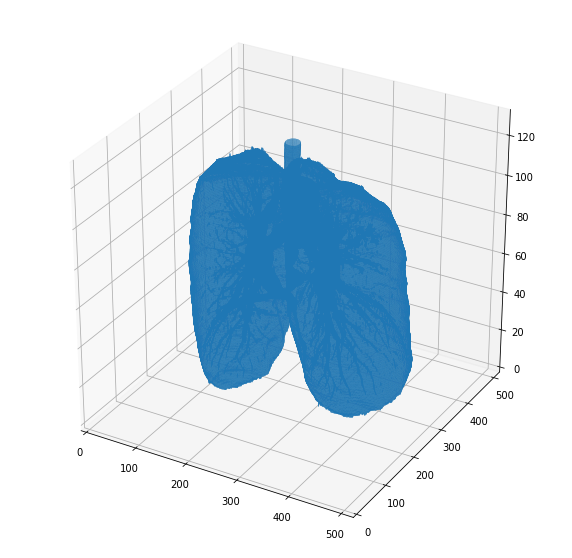

In [24]:
def plot_3d(image, image2, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(0,1,2)
    p = p[:,:,::]
    print(p.shape)
    verts, faces = measure.marching_cubes_classic(p, threshold)
    
    print(verts.shape, faces.shape)
    print(verts, faces)
    
    fig = plt.figure(figsize=(10, 10))
    #ax = Axes3D(fig) 
    ax = fig.add_subplot(111, projection='3d') 

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    colors = [0.6, 0, 0.4]
    mesh.set_facecolor(face_color)
    
    ax.add_collection3d(mesh)
    
    
    
    p2 = image2.transpose(0,1,2)
    p2 = p2[:,:,::]
    verts2, faces2 = measure.marching_cubes_classic(p2, threshold)

    mesh2 = Poly3DCollection(verts2[faces2], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    
    ax2 = fig.add_subplot(111, projection='3d') 
    ax2.add_collection3d(mesh2)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    ax2.set_xlim(0, p.shape[0])
    ax2.set_ylim(0, p.shape[1])
    ax2.set_zlim(0, p.shape[2])

    plt.show()
plot_3d(segmented_lungs_fill, segmented_lungs, 0)

In [40]:

data = img.get_data()
data[:,:, 45] = 0.6

print(segmented_lungs.shape)
segmented_lungs[57, 68, 45] = 100

fig = ipv.figure()
fig = ipv.pylab.volshow(segmented_lungs)
ipv.pylab.show()



fig.tf.rgba = tf_rgba



(512, 512, 122)


In [33]:
tf_rgba = fig.tf.rgba
print(fig.tf.rgba)

[[1.00000000e+00 1.88756727e-10 1.80485139e-34 3.67879441e-03]
 [1.00000000e+00 2.58316227e-10 3.38018092e-34 3.97282964e-03]
 [1.00000000e+00 3.53509376e-10 6.33050629e-34 4.27719045e-03]
 ...
 [6.33050629e-36 3.53509376e-11 1.00000000e+00 4.27719045e-02]
 [3.38018092e-36 2.58316227e-11 1.00000000e+00 3.97282964e-02]
 [1.80485139e-36 1.88756727e-11 1.00000000e+00 3.67879441e-02]]




f = img.get_data()

a = 1
X, Y, Z = np.mgrid[-a:a:25j, -a:a:25j, -a:a:25j]

data = [go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=f.flatten(),
    isomin=-100,
    isomax=100,
    surface=dict(show=True,count=1, fill=0.8),
    slices=go.isosurface.Slices(
        z=go.isosurface.slices.Z(
            show = True,
            locations=[-0.3, 0.5])
    ),
    caps=go.isosurface.Caps(
        z=dict(show=False),
        x=dict(show=False),
        y=dict(show=False)
    ),
)]

layout = go.Layout(
    margin=dict(t=0, l=0, b=0),
    scene=dict(
        camera=dict(
            eye=dict(
                x=1.86,
                y=0.61,
                z=0.98
            )
        )
    )
)

fig = go.Figure(data, layout)

py.iplot(fig, config=dict(showSendToCloud=True), filename='isosurface-with-slices')

# import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
img = nib.load('../data/raw/086e42f6-2077-4d8c-a713-6eddd58a4177_TrainingSet_1_of_2/TrainingSet_1_of_2/CTR_TRN_002.nii.gz')

import plotly.plotly as py
import plotly.graph_objs as go
data = img.get_data()
# x = [i for i in range(0, data.shape[0])]
# y = [j for j in range(0, data.shape[1])]
# z = [l for l in range(0, data.shape[2])]



data = [
    go.Surface(
        z=data
    )
]
layout = go.Layout(
    title='Mt Bruno Elevation',
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='elevations-3d-surface')

In [73]:
x = []
y = []
z = []
data = segmented_lungs

for i in range(0,data.shape[0]):
    for j in range(0, data.shape[1]):
        for l in range(0, data.shape[2]):
            if segmented_lungs[i, j, l] >= 1:
                x.append(i)
                y.append(j)
                z.append(l)
                



In [74]:
x = np.array(x)
y = np.array(y)
z = np.array(z)

x = x / 100
y = y / 100
z = z / 100


In [ ]:
ipv.quickscatter(x, y, z, size=1, marker="sphere")#, color = ['gray']#'red', 'blue', 'white'])

In [62]:
import plotly

plotly.tools.set_credentials_file(username='augt', api_key='VtzWA1dD5oSVUdrj5D82')
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.4
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~augt/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


/home/augt/Public/License2019/clef2019_tuberculosis/.venv/lib/python3.6/site-packages/chart_studio/api/v1/clientresp.py:44: UserWarning:

Estimated Draw Time Too Long

/home/augt/Public/License2019/clef2019_tuberculosis/.venv/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [ ]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib
# x, y = np.meshgrid(x, y)
# from matplotlib import cm
# colormap = cm.coolwarm
# znorm = z - z.min()
# znorm = znorm / znorm.ptp()
# color = colormap(znorm)

# ipv.figure()
# mesh = ipv.plot_surface(x, z, y, color=color[...,:3])
# ipv.show()

ipv.figure()
m = ipv.scatter(x, y, z, color='red', size=10, size_selected=11, color_selected='blue', marker='diamond')
ipv.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')